In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Config
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
PROJECT_ROOT = Path("/Users/venzchenfoo/Documents/All Files/AI and IT/projects/HM_Training_Predictor")
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
FIGURES = PROJECT_ROOT / "reports" / "figures"

In [10]:
df = pd.read_csv(DATA_RAW /"strava_runs_bulk.csv")

print(f"Total runs: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

Total runs: 256
Columns: ['id', 'name', 'start_date', 'start_datetime', 'distance_km', 'moving_time_min', 'pace_min_per_km', 'elevation_gain_m', 'avg_speed_kmh', 'max_speed_kmh', 'avg_heartrate', 'max_heartrate', 'avg_cadence', 'suffer_score', 'elapsed_time_min', 'workout_type']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                256 non-null    int64  
 1   name              256 non-null    object 
 2   start_date        256 non-null    object 
 3   start_datetime    256 non-null    object 
 4   distance_km       256 non-null    float64
 5   moving_time_min   256 non-null    float64
 6   pace_min_per_km   256 non-null    float64
 7   elevation_gain_m  256 non-null    float64
 8   avg_speed_kmh     256 non-null    float64
 9   max_speed_kmh     254 non-null    float64
 10  avg_heartrate     200 non-null    float64
 11  max_heartrate     200 non-null    float64
 12  avg_cadence       199 non-null    float64
 13  suffer_score      0 non-null      float64
 14  elapsed_time_min  256 non-null    float64
 15  workout_type      109 non-null    float64
dtypes: float64(12), int64(1), object(3)
memory u

In [12]:
null_counts = df.isnull().sum()
null_pct = (df.isnull().sum() / len(df) * 100).round(2)

null_df = pd.DataFrame({
    'null_count': null_counts,
    'null_pct': null_pct
}).sort_values('null_pct', ascending=False)

print(null_df[null_df['null_count'] > 0])

               null_count  null_pct
suffer_score          256    100.00
workout_type          147     57.42
avg_cadence            57     22.27
avg_heartrate          56     21.88
max_heartrate          56     21.88
max_speed_kmh           2      0.78


In [13]:
df['start_date'] = pd.to_datetime(df['start_date'])

print(f"Date range: {df['start_date'].min().date()} to {df['start_date'].max().date()}")
print(f"Total distance: {df['distance_km'].sum():.1f} km")
print(f"Total time: {df['moving_time_min'].sum() / 60:.1f} hours")
print(f"Average pace: {df['pace_min_per_km'].mean():.2f} min/km")

Date range: 2023-05-26 to 2025-11-10
Total distance: 2101.5 km
Total time: 205.1 hours
Average pace: 5.90 min/km


In [14]:
df[['distance_km', 'moving_time_min', 'pace_min_per_km', 
    'elevation_gain_m', 'avg_heartrate', 'avg_cadence']].describe()

,distance_km,moving_time_min,pace_min_per_km,elevation_gain_m,avg_heartrate,avg_cadence
count,256.000000,256.000000,256.000000,256.000000,200.000000,199.000000
mean,8.208828,48.065820,5.901641,42.787500,154.096000,82.341709
std,5.446160,32.323116,0.717346,25.370349,10.629048,3.731726
min,1.770000,11.720000,4.840000,0.000000,84.300000,41.000000
25%,5.050000,29.660000,5.400000,30.000000,148.575000,81.450000
50%,6.525000,38.985000,5.840000,36.000000,154.500000,82.600000
75%,9.502500,51.042500,6.212500,52.000000,159.400000,83.950000
max,42.520000,231.580000,9.900000,190.000000,179.500000,87.100000


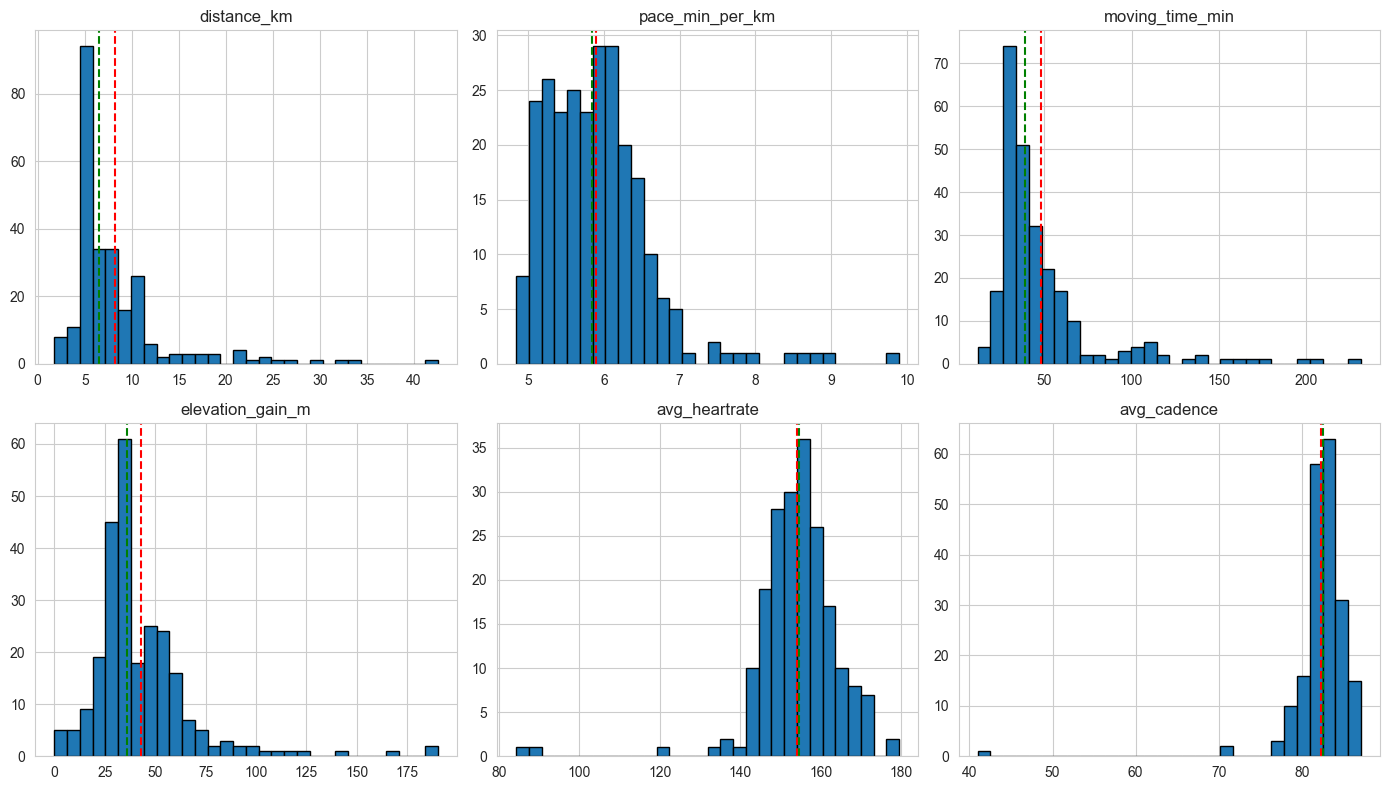

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

cols = ['distance_km', 'pace_min_per_km', 'moving_time_min', 
        'elevation_gain_m', 'avg_heartrate', 'avg_cadence']

for ax, col in zip(axes.flatten(), cols):
    df[col].dropna().hist(bins=30, ax=ax, edgecolor='black')
    ax.set_title(col)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label='mean')
    ax.axvline(df[col].median(), color='green', linestyle='--', label='median')

plt.tight_layout()
plt.savefig(FIGURES / "01_distributions.png", dpi=150)
plt.show()

In [16]:
def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers

print("=== Outlier Analysis ===\n")
for col in ['distance_km', 'pace_min_per_km', 'avg_cadence', 'elevation_gain_m']:
    outliers = detect_outliers_iqr(df[col].dropna())
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers")
        print(f"  Range: {outliers.min():.2f} - {outliers.max():.2f}")
        print(f"  Values: {sorted(outliers.values)[:5]}...\n")

=== Outlier Analysis ===

distance_km: 19 outliers
  Range: 17.00 - 42.52
  Values: [np.float64(17.0), np.float64(17.3), np.float64(17.61), np.float64(19.03), np.float64(19.12)]...

pace_min_per_km: 9 outliers
  Range: 7.46 - 9.90
  Values: [np.float64(7.46), np.float64(7.67), np.float64(7.76), np.float64(8.02), np.float64(8.4)]...

avg_cadence: 5 outliers
  Range: 41.00 - 77.40
  Values: [np.float64(41.0), np.float64(70.5), np.float64(70.9), np.float64(77.2), np.float64(77.4)]...

elevation_gain_m: 14 outliers
  Range: 87.00 - 190.00
  Values: [np.float64(87.0), np.float64(88.0), np.float64(89.0), np.float64(94.0), np.float64(95.0)]...



In [17]:
df[df['avg_cadence'] < 60][['start_date', 'name', 'distance_km', 'pace_min_per_km', 'avg_cadence']]

,start_date,name,distance_km,pace_min_per_km,avg_cadence
29,2025-05-29,Lunch Run,5.09,9.9,41.0


/var/folders/pg/g5gfpcy517v0gffrzxzw6h400000gn/T/ipykernel_30129/3752668338.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(monthly.index.astype(str), rotation=45, ha='right')


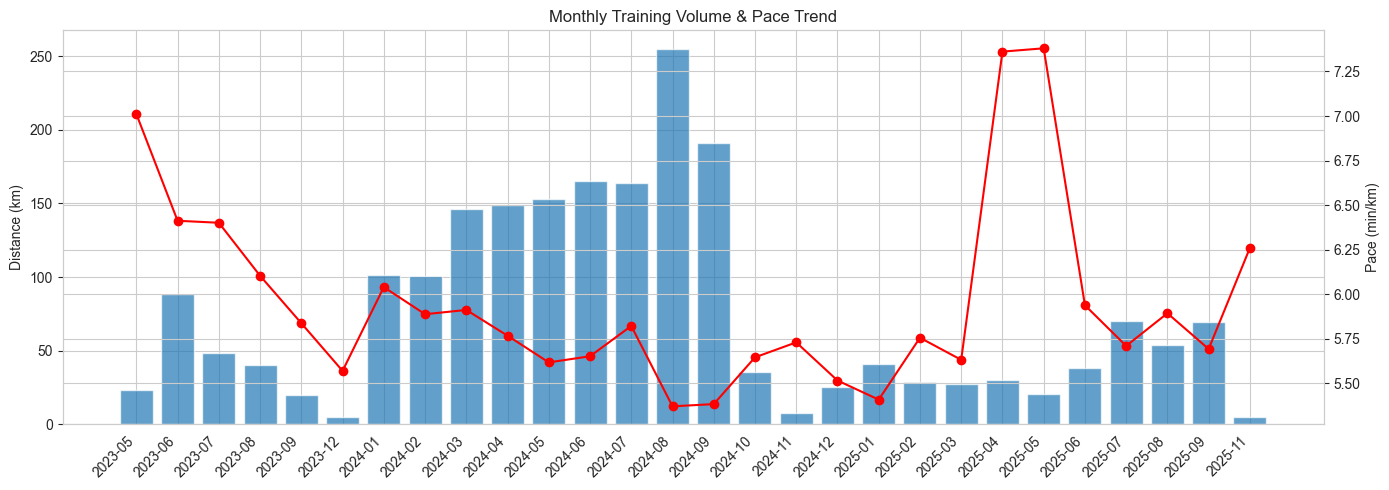

In [18]:
df['month'] = df['start_date'].dt.to_period('M')

monthly = df.groupby('month').agg({
    'distance_km': 'sum',
    'id': 'count',
    'pace_min_per_km': 'mean'
}).rename(columns={'id': 'run_count'})

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.bar(monthly.index.astype(str), monthly['distance_km'], alpha=0.7, label='Monthly km')
ax1.set_ylabel('Distance (km)')
ax1.set_xticklabels(monthly.index.astype(str), rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(monthly.index.astype(str), monthly['pace_min_per_km'], color='red', marker='o', label='Avg pace')
ax2.set_ylabel('Pace (min/km)')

plt.title('Monthly Training Volume & Pace Trend')
plt.tight_layout()
plt.savefig(FIGURES / "02_monthly_trend.png", dpi=150)
plt.show()

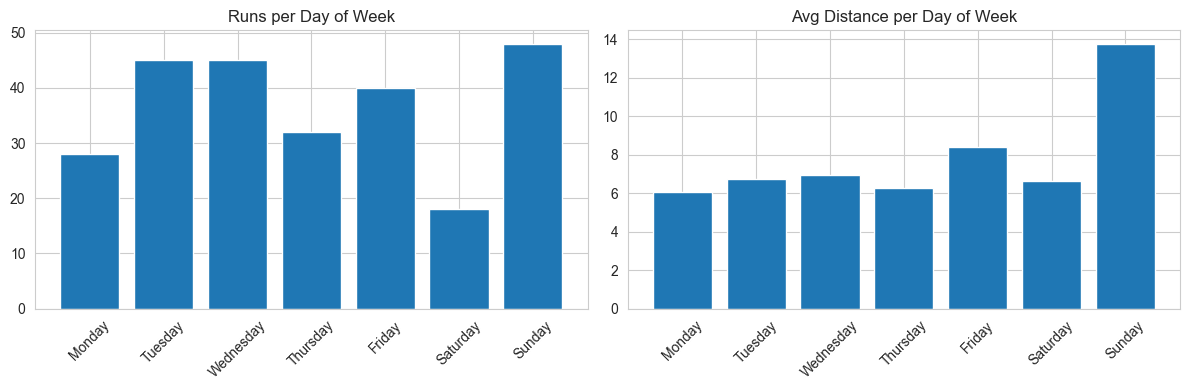

In [19]:
df['day_of_week'] = df['start_date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_pattern = df.groupby('day_of_week').agg({
    'id': 'count',
    'distance_km': 'mean'
}).reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(weekly_pattern.index, weekly_pattern['id'])
axes[0].set_title('Runs per Day of Week')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(weekly_pattern.index, weekly_pattern['distance_km'])
axes[1].set_title('Avg Distance per Day of Week')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / "03_weekly_pattern.png", dpi=150)
plt.show()